In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_squared_error

color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [41]:
df = pd.read_excel('datafix.xlsx', index_col=[0], parse_dates=[0])

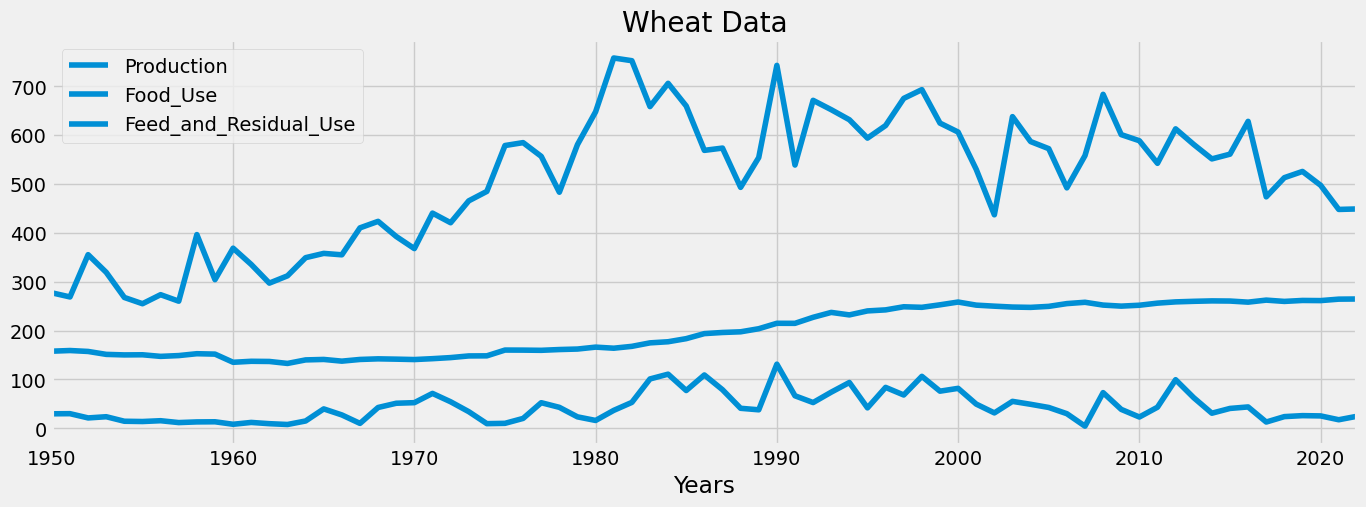

In [42]:
df.plot(style='-',
        figsize=(15, 5),
        color=color_pal[0],
        title='Wheat Data')
plt.show()

Train/Test Split

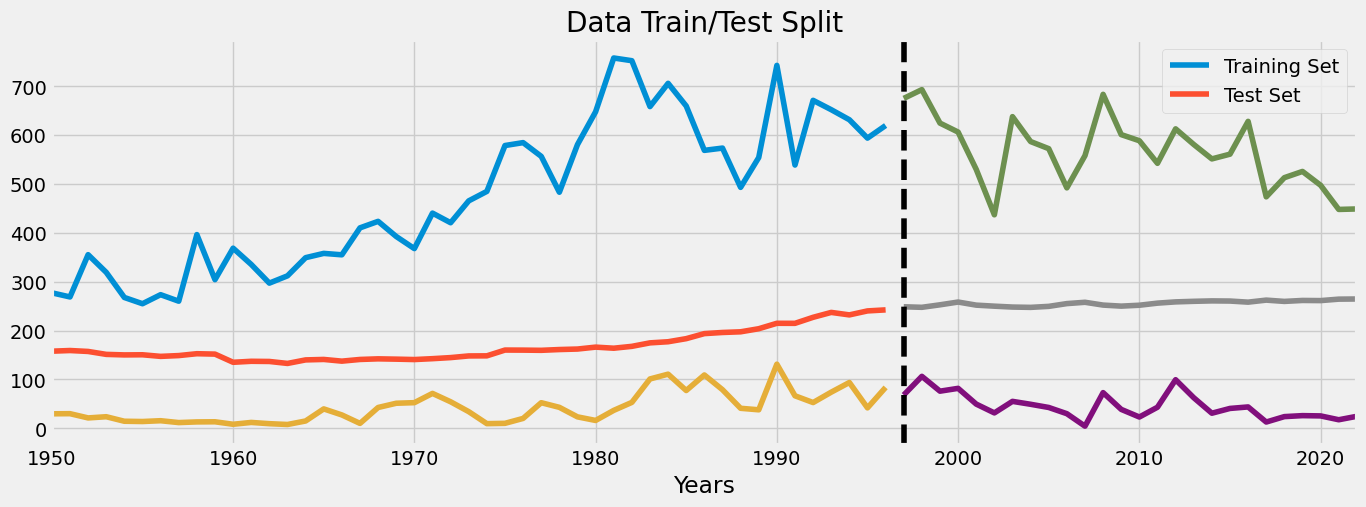

In [43]:
train = df.loc[df.index < '1997']
test = df.loc[df.index >= '1997']

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('1997', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

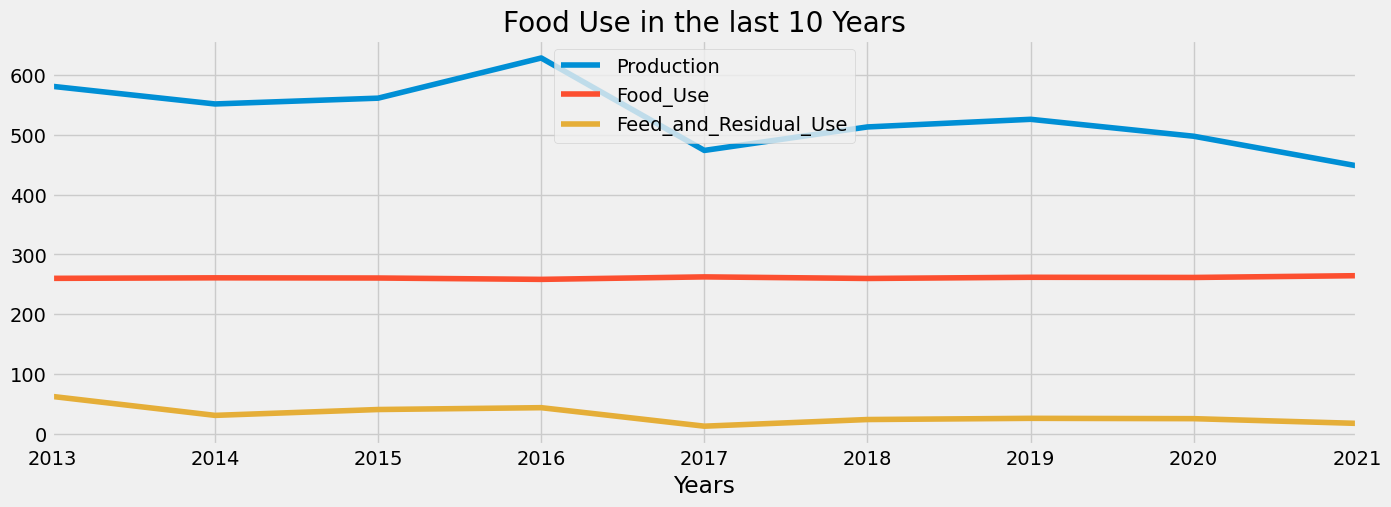

In [44]:
df.loc[(df.index > '2012') & (df.index < '2022')] \
    .plot(figsize=(15, 5), title='Food Use in the last 10 Years')
plt.show()

Feature Creation

In [45]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['Production'] = df.Production
    df['Food Use'] = df.Food_Use
    df['Feed and Residual Use'] = df.Feed_and_Residual_Use
    return df

df = create_features(df)

Visualize our Feature / Target Relationship

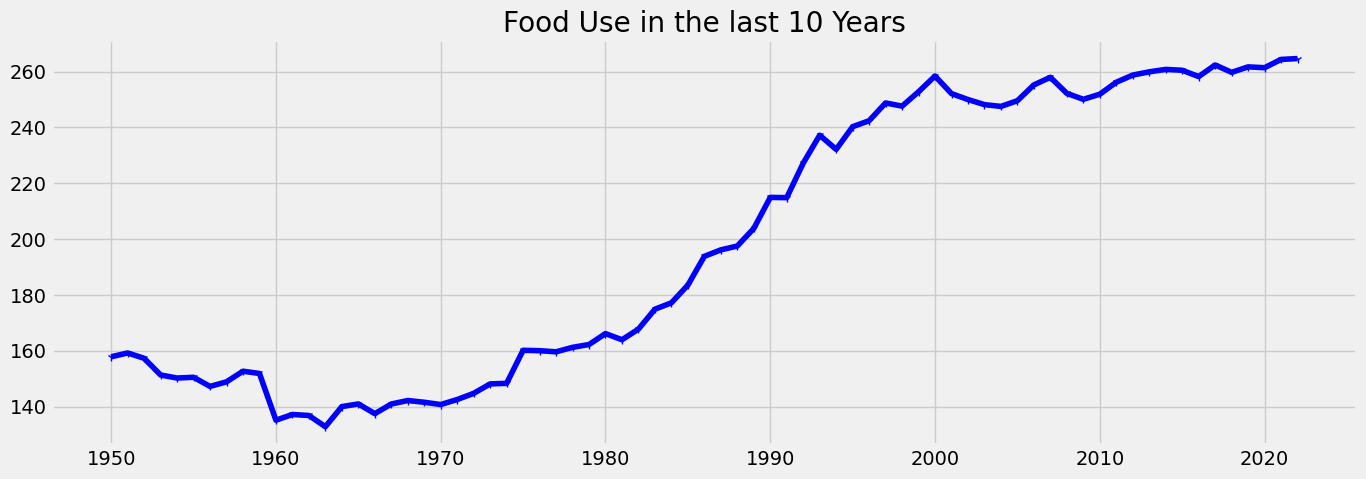

In [46]:
fig, ax = plt.subplots(figsize=(15, 5))
plt.plot(df['Food Use'], color='Blue', marker='1')
ax.set_title('Food Use in the last 10 Years')
plt.show()

Create our Model

In [47]:
train = create_features(train)
test = create_features(test)

FEATURES = ['Food Use']
TARGET = ['Food Use']

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [48]:
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=20000,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[0]	validation_0-rmse:168.30924	validation_1-rmse:253.42627


[100]	validation_0-rmse:65.68246	validation_1-rmse:125.44903
[200]	validation_0-rmse:26.29148	validation_1-rmse:67.84207
[300]	validation_0-rmse:10.79855	validation_1-rmse:41.24499


c:\Users\Kevin Nathanael\anaconda3\envs\tf\lib\site-packages\xgboost\core.py:160: UserWarning: [18:55:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[400]	validation_0-rmse:4.59725	validation_1-rmse:28.51903
[500]	validation_0-rmse:2.05754	validation_1-rmse:22.27726
[600]	validation_0-rmse:0.98123	validation_1-rmse:18.94578
[700]	validation_0-rmse:0.51234	validation_1-rmse:17.23894
[800]	validation_0-rmse:0.29270	validation_1-rmse:16.14378
[900]	validation_0-rmse:0.17231	validation_1-rmse:15.47865
[1000]	validation_0-rmse:0.10308	validation_1-rmse:15.07764
[1100]	validation_0-rmse:0.06215	validation_1-rmse:14.83542
[1200]	validation_0-rmse:0.03765	validation_1-rmse:14.68904
[1300]	validation_0-rmse:0.02283	validation_1-rmse:14.60042
[1400]	validation_0-rmse:0.01385	validation_1-rmse:14.54681
[1500]	validation_0-rmse:0.00840	validation_1-rmse:14.51438
[1600]	validation_0-rmse:0.00512	validation_1-rmse:14.49471
[1700]	validation_0-rmse:0.00312	validation_1-rmse:14.48279
[1800]	validation_0-rmse:0.00196	validation_1-rmse:14.47569
[1900]	validation_0-rmse:0.00128	validation_1-rmse:14.47126
[2000]	validation_0-rmse:0.00095	validation_1-

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=20000, n_jobs=None,
             num_parallel_tree=None, objective='reg:linear', ...)

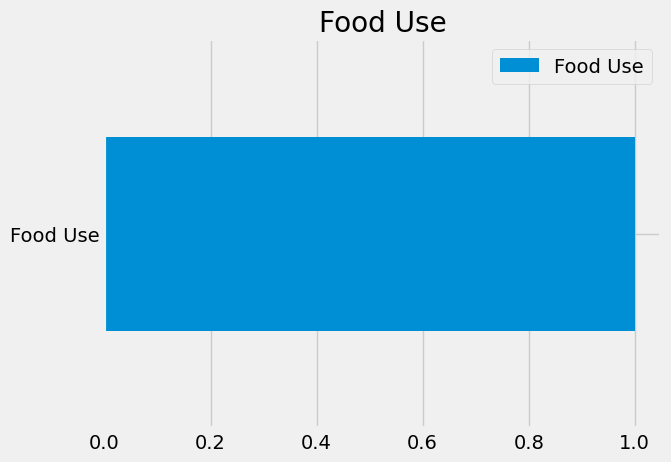

In [49]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['Food Use'])
fi.sort_values('Food Use').plot(kind='barh', title='Food Use')
plt.show()

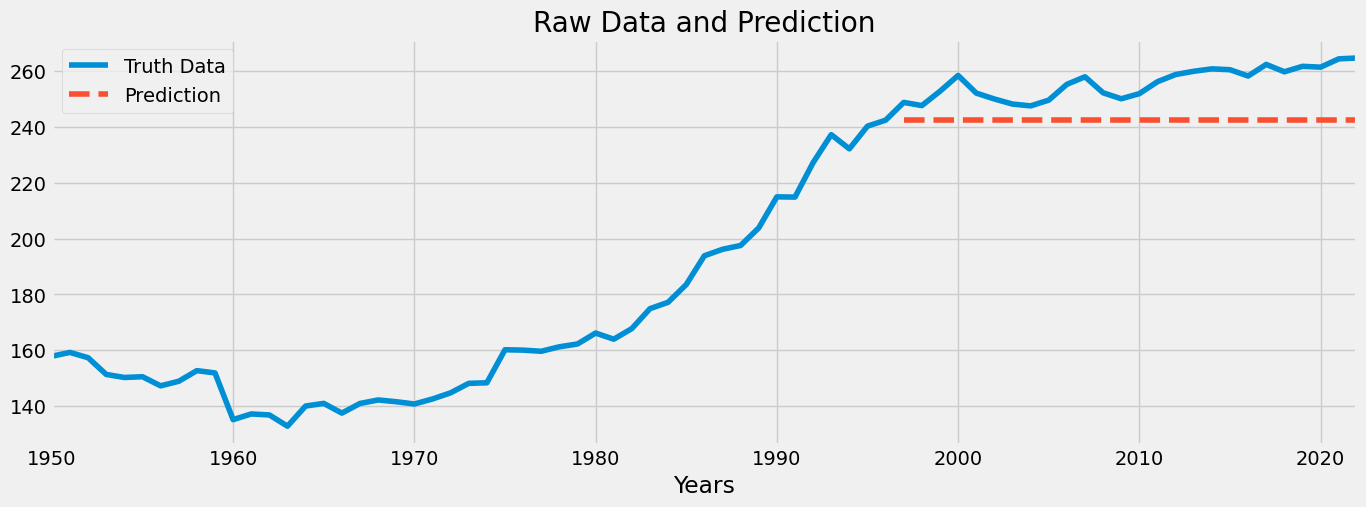

In [50]:
test['prediction'] = reg.predict(X_test)
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)
ax = df[['Food Use']].plot(figsize=(15, 5))
df['prediction'].plot(ax=ax, style='--')
plt.legend(['Truth Data', 'Prediction'])
ax.set_title('Raw Data and Prediction')
plt.show()

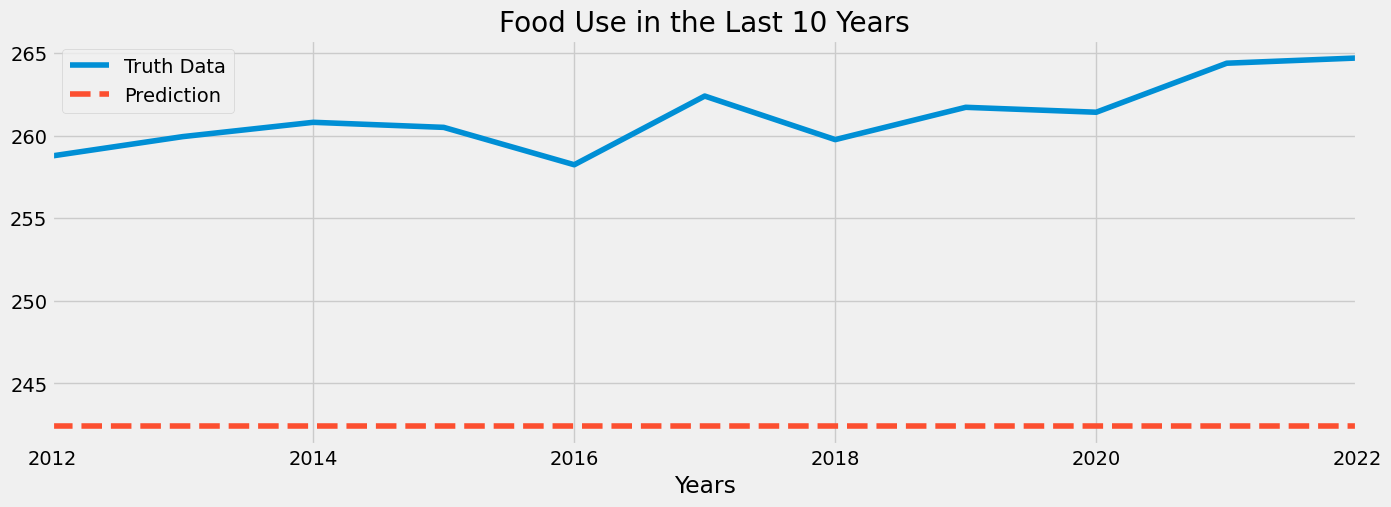

In [51]:
ax = df.loc[(df.index >= '2012') & (df.index <= '2022')]['Food Use'] \
    .plot(figsize=(15, 5), title='Food Use in the Last 10 Years')
df.loc[(df.index >= '2012') & (df.index <= '2022')]['prediction'] \
    .plot(style='--')
plt.legend(['Truth Data','Prediction'])
plt.show()

In [52]:
score = np.sqrt(mean_squared_error(test['Food Use'], test['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 14.47
